In [1]:
from __future__ import division

from pylab import *
import scipy
import time

import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
    

In [14]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'the'

bound_vec = ngram_encode(ngram_str, letter_vecs, alph)


l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))

l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)


l0_state = letter_vecs[alph.find('#'), :]
l4_state = letter_vecs[alph.find('.'), :]


n_steps = 15

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))

In [15]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    
    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state *= np.sign(l1_coef_hist[i, mx1idx])
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state *= np.sign(l2_coef_hist[i, mx2idx])
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state *= np.sign(l3_coef_hist[i, mx3idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2))

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2))

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2))

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T))
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T))
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T))

    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)


the


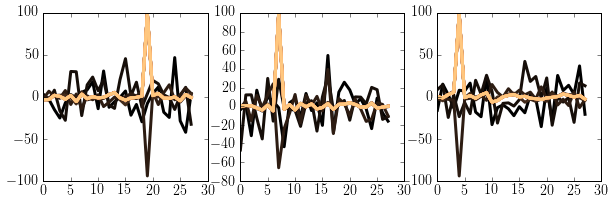

In [16]:
figure(figsize=(10,3))
cols = get_cmap('copper', n_steps)
for i in range(n_steps):
    subplot(131)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    subplot(132)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    subplot(133)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    
    
l1 = alph[np.argmax(l1_coef_hist[-1,:])]
l2 = alph[np.argmax(l2_coef_hist[-1,:])]
l3 = alph[np.argmax(l3_coef_hist[-1,:])]

print l1+l2+l3